In [37]:
import fix_yahoo_finance as yf
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pickle

# Databroker
The DataBroker takes care of the data that we use for the model. 
Keeping an offline version stored for easy use and to reduce download need.

In [35]:
class DataBroker:
    def __init__(self, start_date=datetime.date(2000,1,1)):
        self.data = {}
        self.load_data()
        self.start_date = start_date
        self.today = datetime.datetime.now().date() - datetime.timedelta(days=1)
         
    # Reads the pickle file and initiate the data dictionary.
    def load_data(self):
        try:
            self.data = pickle.load(open("data_store.p", "rb"))
        except FileNotFoundError:
            print("No data was found")
            return False
        print(self.data.keys())
        return True
          
    # Write data to the pickle file.
    def save_data(self):
        pickle.dump(self.data, open("data_store.p", "wb"))
        return True
    
    # Updates data for every company to the last day of trading
    def update_all_companies(self):
        for company in self.data.keys():
            self.update_company(company)
        return True
        
    # Updates a the date of a company, if no data exists adds the company to the database. 
    def update_company(self, company):        
        if company in self.data.keys():      
            cur_date = self.data[company].index.max().date()
            diff = (self.today - cur_date).days
            if diff > 0 and diff < 3 and datetime.date.today().weekday() >= 5:
                return True
            elif diff > 0:
                append_data = yf.download([company], start=cur_date, end=self.today)
                self.data[company].append(append_data)
        else:
            self.data[company] = yf.download([company], start=self.start_date, end=self.today)
        self.save_data()
        return True
    
    # Returns the data of collected on a company
    def load_company(self, company, start_date=None, end_date=None):
        if not start_date:
            start_date = self.start_date
        if not end_date: 
            end_date = self.today
        return self.data[company][start_date:end_date]
    
    # Clears the database and overwrites the data-file.
    def clear_database(self):
        self.data = {}
        self.save_data()
        return True
    
    # Returns the "Opening" price for a specific company at a specific date. If no date provided, last day of trading will be used
    def get_company_stock_price(self, company, date):
        if not date:
            return self.data[company]["Open"][-1]
        date_index = self.data[company]["Open"].index.get_loc(date, method='pad')
        return self.data[company]["Open"][date_index]

# Trader
A baseline agent, capable of trading stocks and ready for simulations. 
Contains no trading-logic, and agents should inherit and build trading logic on top of this.

In [3]:
class Trader:
    def __init__(self, DataBroker, start_funds, start_date=datetime.datetime(2000,1,1)):
        self.DataBroker = DataBroker
        self.balance = start_funds
        self.start_funds = start_funds
        self.date = start_date
        self.owning = {}
        
    # Updates the date of the Trader. Is used for simulations.
    def set_date(self, date):
        self.date = date
        return True
    
    # Resets the balance back to start and clears the portfolio.
    def reset_balance_and_portfolio(self):
        self.balance = start_funds
        self.owning = {}
        return True
    
    # Retuning a action point of doing nothing for a specific date.
    def do_nothing(self, date):
        return (date, 0, None, 0 ,0)
    
    # Buys x stocks from a company, only if x*price < balance. Adds it to portfolio and updates balance. 
    # Returning the action of buying x stocks 
    def buy_stock(self, date, company, price, amount):
        if amount * price > self.balance:
            return self.do_nothing(date)
        if company in self.owning:
            self.owning[company] = self.owning[company] + amount
        else:
            self.owning[company] = amount 
        self.balance = self.balance - amount * price
        return (date, 1, company, price, amount)
    
    # Sells stocks only if owning said stocks. 
    def sell_stock(self, date, company, price, amount):
        if company not in self.owning or self.owning[company] <= 0:
            return self.do_nothing(date)
        to_sell = min(self.owning[company], amount)
        self.owning[company] = self.owning[company] - to_sell
        self.balance = self.balance + (to_sell * price)
        return (date, -1, company, price, to_sell)
    
    # Getting the value of a portfolio using stock price of 'date' provided, if no date given, last tradingday is used.
    def get_portfolio_worth(self, date=datetime.date.today()):
        worth = 0
        for c in self.owning:
            if self.owning[c] > 0:
                worth = worth + self.DataBroker.get_company_stock_price(c, date) * self.owning[c]
        return worth
    
    # The total worth of the trader, balance + portfolio
    def get_total_worth(self, date=datetime.date.today()):
        return self.balance + self.get_portfolio_worth(date)
    
    # Abstract method to be implemented in each agent
    def predict(self, date):
        # Return an action() #(date, 0, "appl", 200, 2)
        """Method shall be implemented in each trader"""
        return 
    
    # Predicting next, used for simulations using the date stored in trader run prediction.
    def predict_next(self):
        prediction = self.predict(self.date)
        self.date = self.date + datetime.timedelta(days=1)
        return prediction

# Simple Algo
A simple trader, trading based on low-level math and logic. Trades only a single stock
$$ action = \begin{cases} buy, & if ~ \dfrac{\text{price today}}{mean(\text{x days trading})} > 1 + y \\ 
sell, & if~ \dfrac{\text{price today}}{mean(\text{x days trading})} < 1 - y \\
nothing, & elseway \end{cases} $$

In [4]:
class SimpleTrader(Trader):
    
    def __init__(self, DataBroker, start_funds, start_date, company, days=5, percent=0.05):
        Trader.__init__(self, DataBroker, start_funds, start_date)
        self.days = days
        self.percent = percent
        self.company = company
        
        self.data = self.DataBroker.load_company(self.company)["Open"]
        self.date = self.data.index[0].date()
        
        self.name = 'SimpleTrader_{0}_{1}'.format(days, percent)
        self.owning = {}
        
    def predict(self, date):
        if date not in self.data.index:
            return self.do_nothing(date)
        date_index = self.data.index.get_loc(date)
        df = self.data[max(0, date_index-self.days) : date_index+1]
        mean = np.mean(df[:-1])
        if df[-1] / mean > 1 + self.percent:
            return self.buy_stock(date, self.company, df[-1], 1)
        elif df[-1] / mean < 1 - self.percent:
            return self.sell_stock(date, self.company, df[-1], 100000)
        return self.do_nothing(date)      

# Simulater
Helper functions used to simulate one or more Traders using date within a given timeframe. Will provie both profits and actionsets.

In [74]:
# Simulate the Trader acting within 'start_date' and 'end_date', returning the series of actions taken. 
def simulate_trader(Trader, start_date, end_date=datetime.date.today(), no_actions=False):
    Trader.set_date(start_date)
    
    profit = 0
    
    balances = [(Trader.date, Trader.start_funds)]
    
    actions = []
    for days in range((end_date-start_date).days):
        action = Trader.predict_next()
        balances.append((action[0], Trader.get_total_worth(action[0])))
        if (action[1] == 1):
            profit = profit - action[4] * action[3]
        elif (action[1] == -1):
            profit = profit + action[4] * action[3]
        if not(no_actions):
            actions.append(action)
    
    print("{0}; Profit: {1:1.0f}. Worth: {2:1.0f}".format(Trader.name, profit, Trader.get_portfolio_worth()))
    
    if no_actions:
        return int(balances[-1][1])
    
    return balances[-1][1], (Trader.name, Trader.start_funds, balances, actions)  

def simulate_traders(Traders, start_date, end_date=datetime.date.today(), no_actions=False):
    res = []
    for Trader in Traders:
        res.append(simulate_trader(Trader, start_date,end_date, no_actions))
    return res

# Visualizer
A set of visualization tools, taking a simulation or a list of simulations as inputs.

In [6]:
def visualize_portfolios(simulation_datas):
    plt.figure(figsize=(20,5))   
    
    if not isinstance(simulation_datas, list):
        simulation_datas = [simulation_datas]
    
    for simulation_data in simulation_datas:

        profit = simulation_data[0]
        simulation = simulation_data[1]

        name = simulation[0]
        data_ = simulation[2]

        balances = []
        time = []

        for i in data_:
            time.append(i[0])
            balances.append(i[1])
    
        plt.plot(time, balances, label=name, linewidth=2.5) 
    
    plt.xlabel("Time of investment", fontsize=14)
    plt.ylabel("Dollars", fontsize=14)
    plt.title("Portfoliovalue over time", fontsize=18)
    plt.legend()
    plt.show()
    return balances[-1]

In [30]:
def visualize_buy_sell(simulation_data):
    plt.figure(figsize=(20,5))   

    profit = simulation_data[0]
    simulation = simulation_data[1]

    name = simulation[0]
    data_ = simulation[3]

    amounts = []
    time = []
    trades = 0

    for i in data_:
        time.append(i[0])
        amounts.append(i[1]*i[4])
        trades = trades + abs(i[1])

    #mask_green = [amount for amount in amounts if amount > 0]
    #mask_red = [amount for amount in amounts if amount < 0]
    
    mask_green = [amount if amount > 0 else 0 for amount in amounts]
    mask_red = [amount if amount < 0 else 0 for amount in amounts]
        
    plt.bar(time, mask_green, color='green')
    plt.bar(time, mask_red, color='red')
    #plt.bar(time, amounts, label=name) 
    
    plt.xlabel("Time of investment", fontsize=14)
    plt.ylabel("Stocks Buy/Sells", fontsize=14)
    plt.title("Buy and sells of stocks over time", fontsize=18)
    plt.show()
    return trades

In [140]:
def visualize_variations_2d(balances, x, x_label=None):
    fig = plt.figure(figsize=(20,5))
    plt.plot(x, balances)
    plt.ylabel("Balance")
    if x_label:
        plt.xlabel(x_label)
    else:
        plt.xlabel("Variation")
    
    plt.show()

In [149]:
def visualize_variations_3d(balances, x, y, x_label=None, y_label=None):
    dim = len(x)
    
    (x, y) = np.meshgrid(np.array(x), np.array(y))
    z = np.reshape(np.array(balances), (-1, dim))
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, z)
    fig.tight_layout()
    plt.show()

# Running it

In [36]:
broker = DataBroker()

dict_keys(['PNDORA.CO', 'VWS.CO', 'DANSKE.CO'])


In [9]:
broker.update_company("DANSKE.CO")

True

In [62]:
simple_005 = SimpleTrader(broker, 100000, datetime.date(2000, 1,1), "DANSKE.CO", days=5, percent=0.05)
simple_0025 = SimpleTrader(broker, 100000, datetime.date(2000, 1,1), "VWS.CO", days=5, percent=0.05)
simple_0005 = SimpleTrader(broker, 100000, datetime.date(2000, 1,1), "PNDORA.CO", days=5, percent=0.05)
start = datetime.date(2018,1,1)
res = simulate_traders([simple_0005, simple_0025, simple_005], start)

SimpleTrader_5_0.05; Profit: -567. Worth: 0
SimpleTrader_5_0.05; Profit: -3760. Worth: 4059
SimpleTrader_5_0.05; Profit: -33. Worth: 0


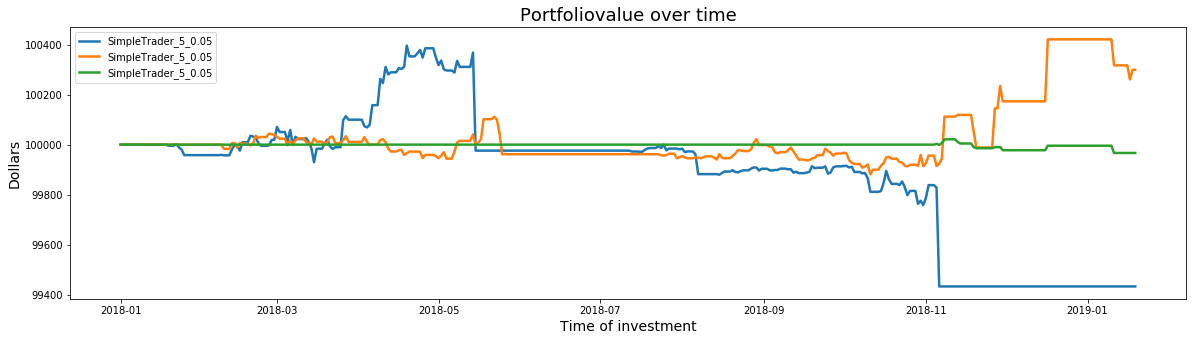

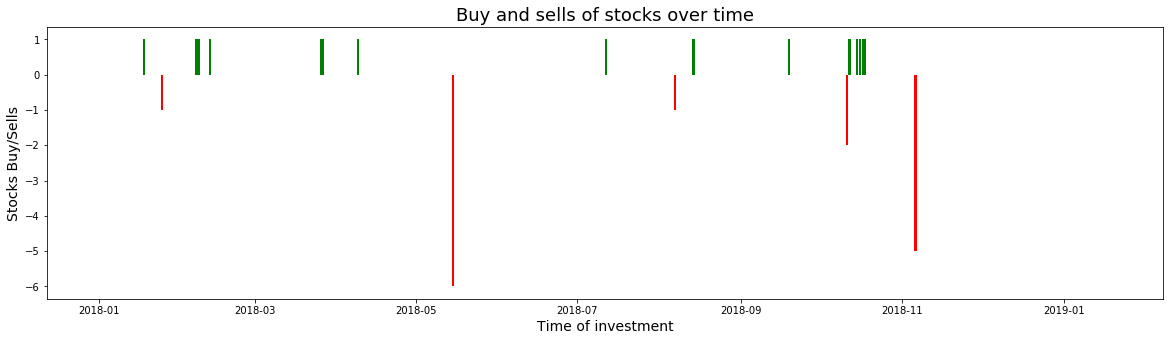

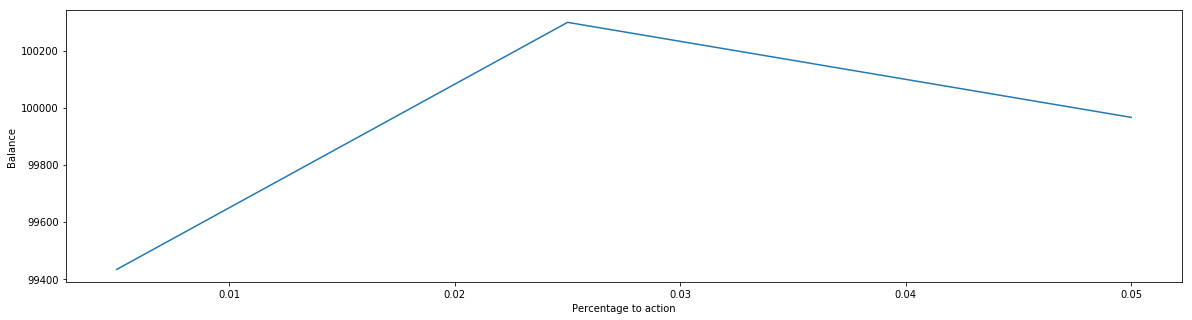

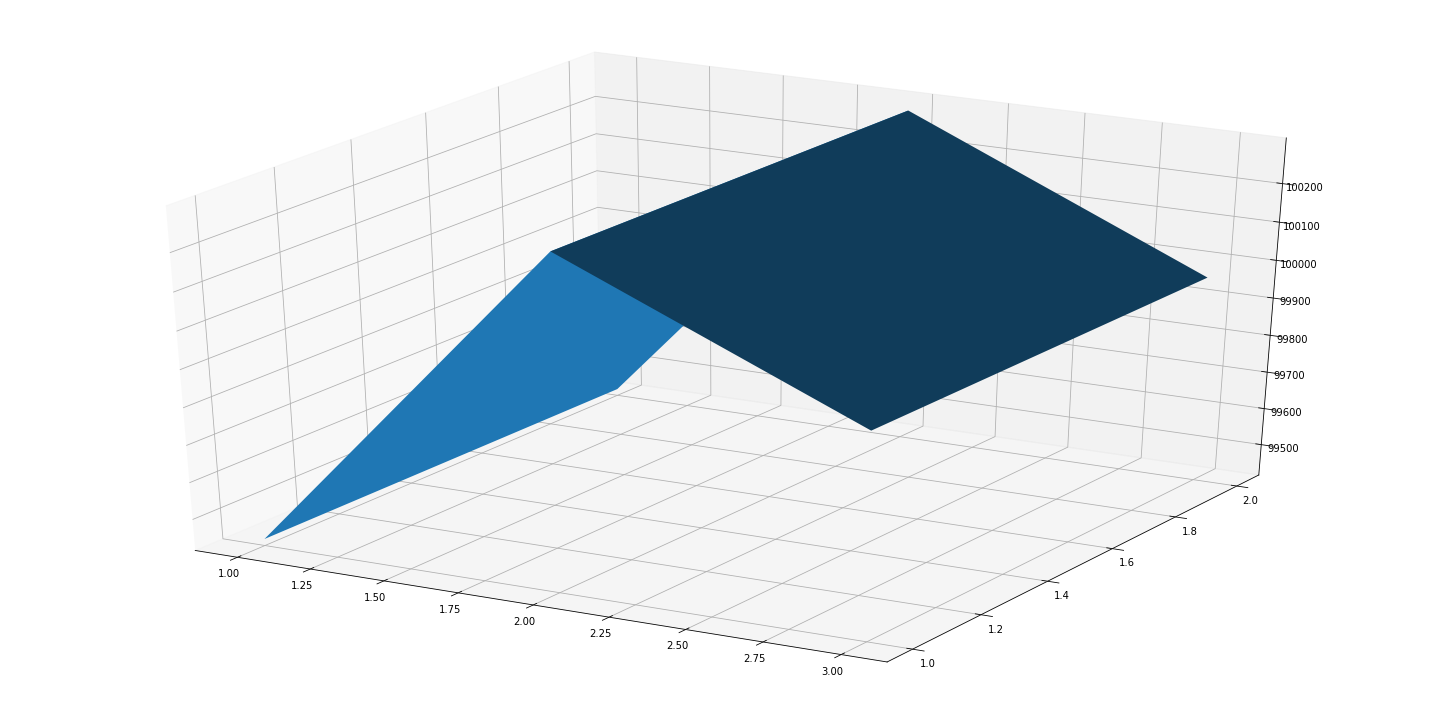

In [151]:
visualize_portfolios(res)
visualize_buy_sell(res[0])
visualize_variations_2d(simulations, [0.005, 0.025, 0.05], x_label="Percentage to action")
visualize_variations_3d(simulations*2, [1, 2, 3], [1, 2])